# MODELO CLASIFICADOR

1) Separar dataset en set de training y set de test -> train_test_split

2) Ajustar hiperparámetros para los distintos modelos de clasificación:

    a) K-Neighbors
    
    b) SVC
    
    c) Árbol de decisión
    
    d) Ensembles (Random Forest, XGBoost, Bagging Classifier...)
    
*Nota: espero mejor resultado de los clasificadores basados en árboles de decisión al no haber hecho escalado de los datos.*
    
3) Análisis de resultados: Classification report, matriz de confusión y elección del modelo
 

**Librerías necesarias**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pickle

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import altair as alt

%matplotlib inline
plt.style.use('ggplot')

#Librerías para modelos

#k-neighbors
from sklearn.neighbors import KNeighborsClassifier
#SVC
from sklearn.svm import SVC
#Arbol de decision
from sklearn.tree import DecisionTreeClassifier
#Regresión logística
from sklearn.linear_model import LogisticRegression
#Para agrupar clasificadores
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE

from sklearn.metrics import classification_report, confusion_matrix, precision_score

#Para representar el arbol

import pydotplus
from IPython.display import Image
from sklearn import tree

In [2]:
pd.options.display.max_columns= None

Descarga de datos previamente procesados y almacenados en *data_processed/data_processed_definitive.csv* 

In [3]:
df=pd.read_csv('../data_processed/data_processed_definitive.csv',sep=';',index_col=False,parse_dates=['FECHA'])
df.head(3)

,FECHA,PERIODO,MES,WD,PRECIO_MD_ESP,ACOPLADO_FR,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,CARBON_D-1,EMB_ANUALES,EMB_HIPERANUALES,RESERVA
0,2015-10-01,1,10,4,56.65,0,0,2196.1,24517.1,10060.7,326.43,3714,4909,1
1,2015-10-01,2,10,4,53.50,0,0,2064.4,23168.6,10060.7,307.80,3714,4909,0
2,2015-10-01,3,10,4,49.69,0,0,1866.5,22437.2,10060.7,298.16,3714,4909,0


### 1) Creo train_test_set

**NOTA:** Tras la exploración de datos, en un primer intento decido quedarme con todos los features seleccionados.

In [4]:
attributes_column = list(df.drop(['FECHA','RESERVA'],axis=1).columns)  #12 en total

In [6]:
X=df[attributes_column]
y=df['RESERVA']

Aplico train_test_split para separar aleatoriamente mi dataset en un set de entrenamiento y otro de test fijando la semilla.

Como en el notebook de exploración se veía que algunos features como ACOPLAMIENTO_FR estaban sesgados o, por ejemplo, la magnitud de PRECIO_MD era muy distinta un año vs. otro, compruebo que mis subconjuntos son representativos del set entero con algunos gráficos.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Features**

In [111]:
X_train.describe()

,PERIODO,MES,WD,PRECIO_MD_ESP,ACOPLADO_FR,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,CARBON_D-1,EMB_ANUALES,EMB_HIPERANUALES
count,21040.000000,21040.000000,21040.000000,21040.000000,21040.000000,21040.000000,21040.000000,21040.000000,21040.000000,21040.000000,21040.000000,21040.000000
mean,12.547006,6.538356,4.075998,48.806784,0.082034,0.576521,5467.314468,28695.967590,8607.888303,315.277814,4624.794772,4151.998004
std,6.924256,3.442789,2.020141,14.931644,0.490143,0.494122,3184.502004,4611.361297,744.464450,50.804636,1462.593847,1302.463105
min,1.000000,1.000000,1.000000,2.060000,-1.000000,0.000000,240.800000,17982.600000,5693.700000,151.940000,2222.000000,2138.000000
25%,7.000000,4.000000,2.000000,40.200000,0.000000,0.000000,3005.175000,24745.200000,8120.400000,280.642500,3429.000000,3137.000000
50%,13.000000,7.000000,4.000000,49.630000,0.000000,1.000000,4812.650000,28956.950000,8679.100000,327.195000,4545.000000,4143.000000
75%,19.000000,10.000000,6.000000,59.452500,0.000000,1.000000,7274.200000,32277.650000,9153.600000,351.990000,5726.000000,4954.000000
max,24.000000,12.000000,7.000000,101.990000,1.000000,1.000000,16952.600000,41297.900000,10070.400000,517.780000,7105.000000,6472.000000


In [112]:
X_test.describe()

,PERIODO,MES,WD,PRECIO_MD_ESP,ACOPLADO_FR,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,CARBON_D-1,EMB_ANUALES,EMB_HIPERANUALES
count,5261.000000,5261.000000,5261.000000,5261.000000,5261.000000,5261.000000,5261.000000,5261.000000,5261.000000,5261.000000,5261.000000,5261.000000
mean,12.317430,6.458088,4.100361,48.473013,0.081924,0.569283,5527.660483,28586.211348,8605.389166,314.152889,4640.454856,4166.062346
std,6.910425,3.473529,2.020946,15.048083,0.493242,0.495224,3191.866221,4632.741771,750.359891,51.323110,1469.714441,1307.213778
min,1.000000,1.000000,1.000000,2.060000,-1.000000,0.000000,281.600000,17728.400000,5693.700000,143.340000,2222.000000,2138.000000
25%,6.000000,3.000000,2.000000,40.000000,0.000000,0.000000,3097.200000,24691.200000,8122.900000,278.880000,3429.000000,3137.000000
50%,12.000000,6.000000,4.000000,49.190000,0.000000,1.000000,4856.000000,28786.800000,8679.100000,326.610000,4572.000000,4266.000000
75%,18.000000,10.000000,6.000000,59.450000,0.000000,1.000000,7351.800000,32226.600000,9154.400000,351.750000,5726.000000,5004.000000
max,24.000000,12.000000,7.000000,99.180000,1.000000,1.000000,16471.600000,40921.600000,10070.400000,503.540000,7105.000000,6472.000000


**Distribución de features**

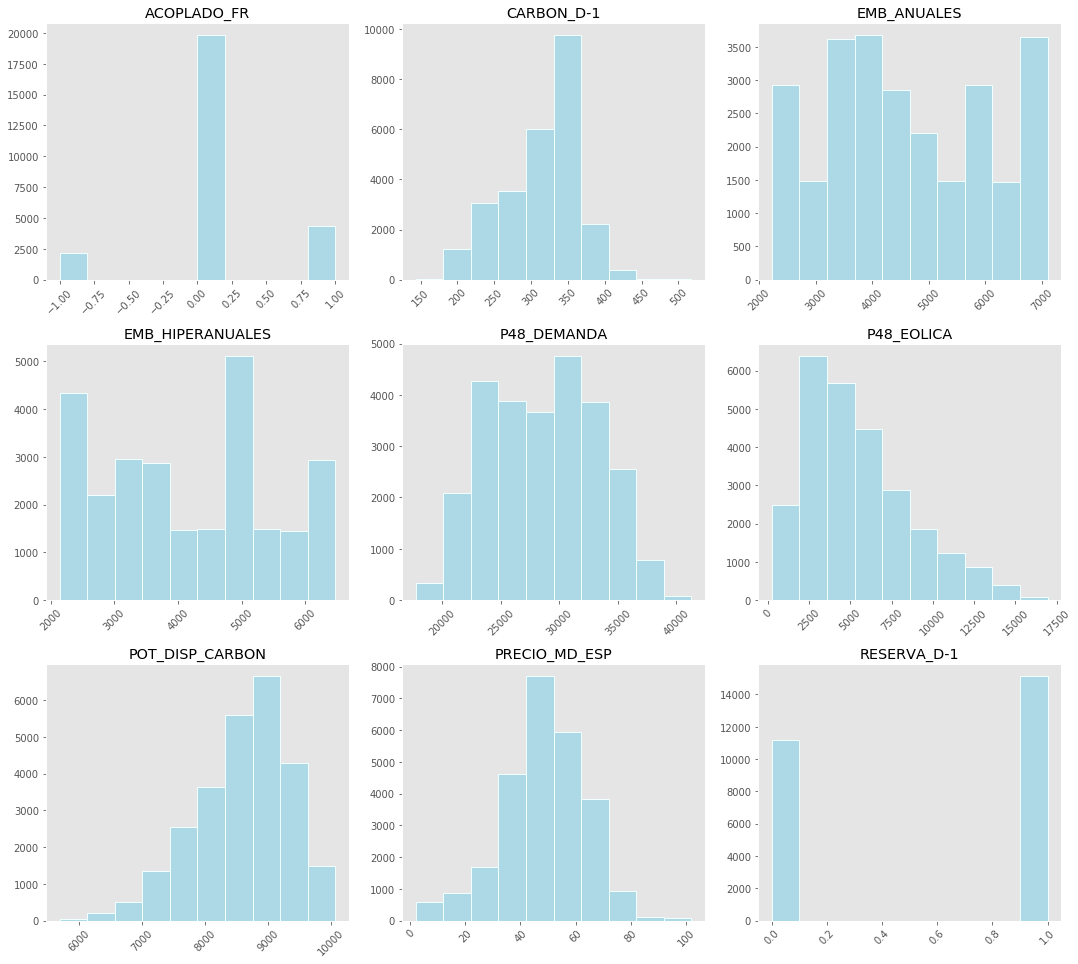

In [9]:
fig = X.drop(['MES','PERIODO','WD'],axis=1).hist(color='lightblue',
                                                    edgecolor='azure', linewidth=1.0,
                                                    xlabelsize=10, ylabelsize=10,
                                                    xrot=45, yrot=0,
                                                    figsize=(10,9),
                                                    grid=False)
plt.tight_layout(rect=(0, 0, 1.5, 1.5))  

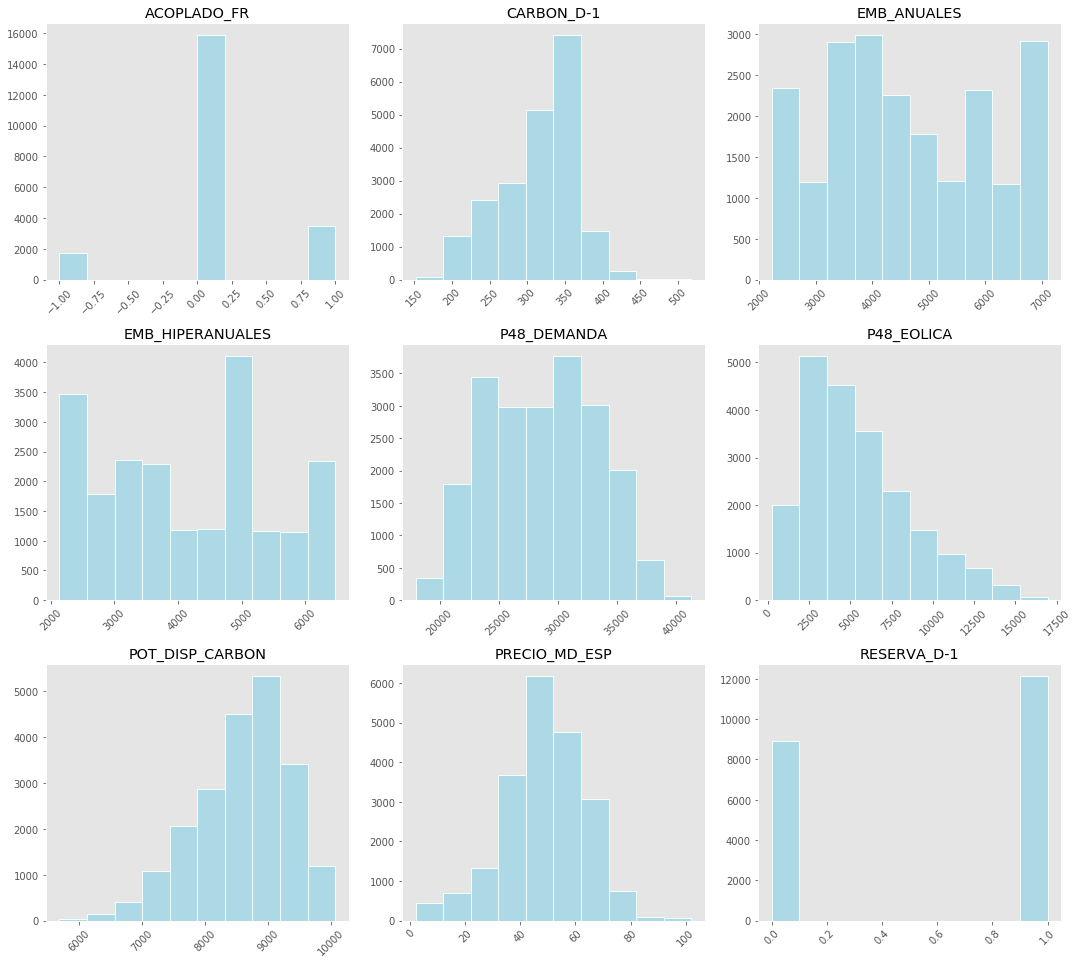

In [10]:
fig = X_train.drop(['MES','PERIODO','WD'],axis=1).hist(color='lightblue',
                                                    edgecolor='azure', linewidth=1.0,
                                                    xlabelsize=10, ylabelsize=10,
                                                    xrot=45, yrot=0,
                                                    figsize=(10,9),
                                                    grid=False)
plt.tight_layout(rect=(0, 0, 1.5, 1.5))  

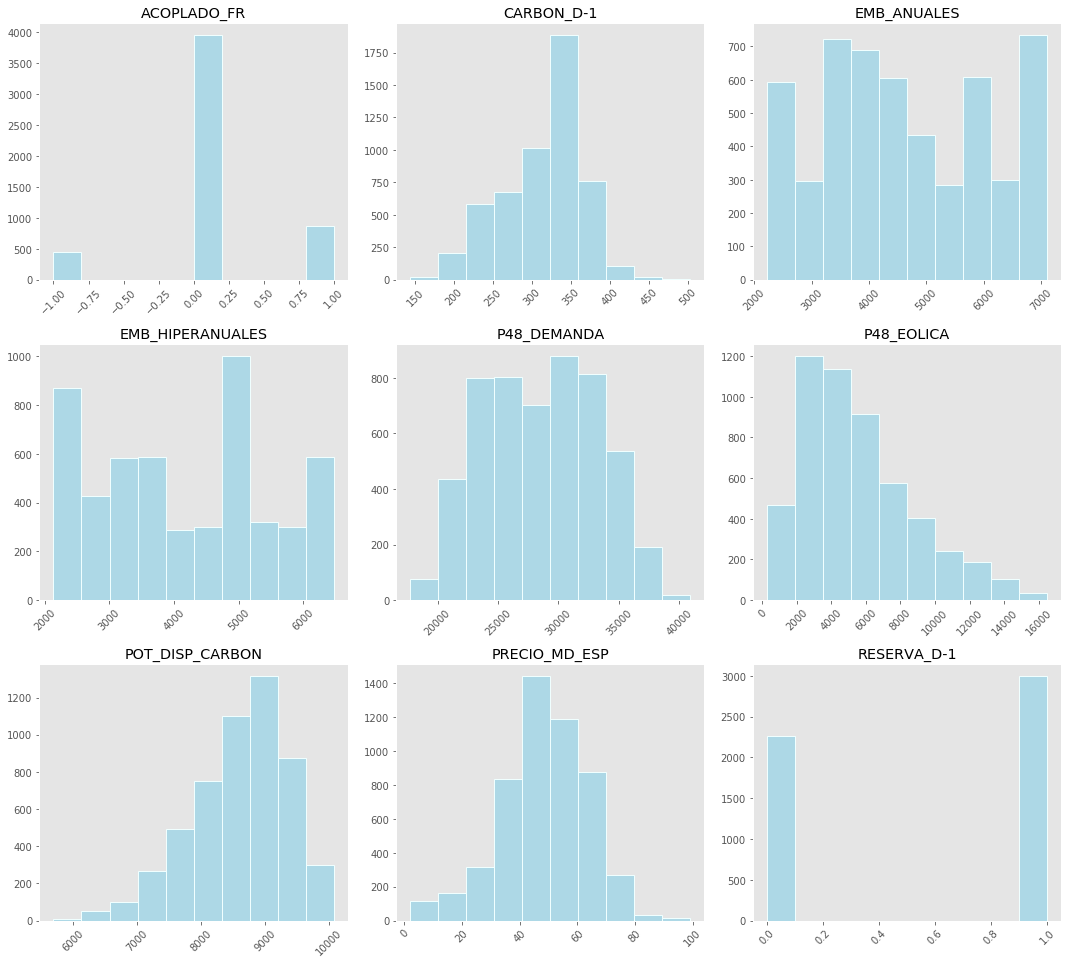

In [11]:
fig = X_test.drop(['MES','PERIODO','WD'],axis=1).hist(color='lightblue',
                                                    edgecolor='azure', linewidth=1.0,
                                                    xlabelsize=10, ylabelsize=10,
                                                    xrot=45, yrot=0,
                                                    figsize=(10,9),
                                                    grid=False)
plt.tight_layout(rect=(0, 0, 1.5, 1.5))  

**Comportamiento target RESERVA**

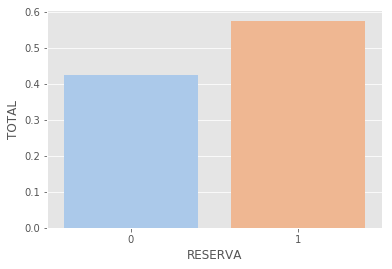

RESERVA=1: 0.576


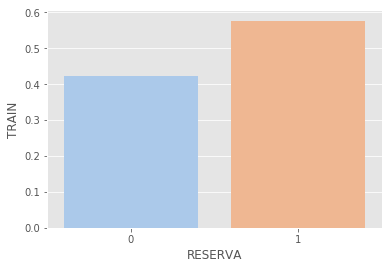

RESERVA=1: 0.577


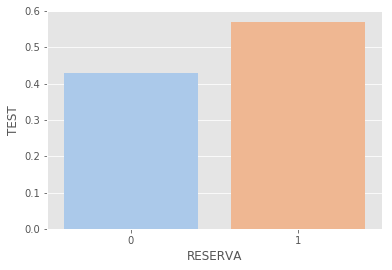

RESERVA=1: 0.571


In [8]:
PORC=y.value_counts(normalize=True,sort=False).reset_index()
PORC.columns=(['RESERVA','TOTAL'])
PORC['TRAIN']=y_train.value_counts(normalize=True,sort=False).values
PORC['TEST']=y_test.value_counts(normalize=True,sort=False).values

sns.barplot(x='RESERVA',y='TOTAL',data=PORC,palette='pastel');
plt.show()
print('RESERVA=1: %.3f' %PORC['TOTAL'].loc[1])

sns.barplot(x='RESERVA',y='TRAIN',data=PORC,palette='pastel');
plt.show()
print('RESERVA=1: %.3f' %PORC['TRAIN'].loc[1])

sns.barplot(x='RESERVA',y='TEST',data=PORC,palette='pastel');
plt.show()
print('RESERVA=1: %.3f' %PORC['TEST'].loc[1])

### 2) Pruebo diferentes modelos

Utilizo **GridSearchCV** para ajustar hiperparámetros.

Como métrica utilizo **accuracy**: porcentaje total de los aciertos del modelo.


#### a) KNN

In [69]:
clfk_0 = KNeighborsClassifier()
print(clfk_0.get_params())

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


Parámetros a seleccionar: 

* **n_neighbors:** nº de vecinos. Agrupa por cercanía. 

In [70]:
clfk=GridSearchCV(KNeighborsClassifier(n_neighbors=1),
                 param_grid={"n_neighbors": [3,5,7,15,100]},
                 scoring="accuracy",
                 cv=10)

clfk.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 7, 15, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [71]:
clfk.best_params_

{'n_neighbors': 3}

In [72]:
clfk.best_score_

0.6381178707224334

In [73]:
clfk_1=clfk.best_estimator_

In [74]:
clfk_1.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [75]:
accuracy_score(y_test, clfk_1.predict(X_test))

0.6468352024329975

#### b) SVC

In [91]:
clfsvc_0=SVC(random_state=42)
print(clfsvc_0.get_params())

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


Parámetros a seleccionar: 

* **kernel:** rbf (para casos no lineales)

* **gamma:** para controlar overfitting

* **C**: cuánta suma del error estoy dispuesta a aceptar. Como sé que tengo outliers en PRECIO_MD_ESP que decidí no quitar, probaré con C más pequeños para tratar de generalizar mejor.

Tan solo pruebo con el tipo kernel **rbf**. El entrenamiento es muy lento, sobretodo al no tener en una escala similar las variables.

In [92]:
clfsvc=GridSearchCV(SVC(kernel="rbf",C=1,gamma=1,random_state=42),  
                 param_grid={"gamma": [10,100,1000,10000],"C":[0.1,1,10]},    
                 scoring="accuracy",
                 cv=5)
clfsvc.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': [10, 100, 1000, 10000], 'C': [0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [93]:
clfsvc.best_params_

{'C': 0.1, 'gamma': 10}

In [94]:
clfsvc.best_score_

0.5767585551330798

In [95]:
clfsvc_1=clfsvc.best_estimator_

In [96]:
clfsvc_1.fit(X_train,y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [97]:
accuracy_score(y_test, clfsvc_1.predict(X_test))

0.5708040296521574

#### c) Decission Tree

In [19]:
clfd_0=DecisionTreeClassifier(random_state=42)
print(clfd_0.get_params())

{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 42, 'splitter': 'best'}


Parámetros a seleccionar: 

* **min_samples_leaf:** mínimo número de muestras que debe tener un nodo.

* **max_depth:** máxima profundidad del árbol, para evitar overfitting.


In [20]:
clfd = GridSearchCV(DecisionTreeClassifier(min_samples_leaf=20,max_depth=3,random_state=42),
                            param_grid={"min_samples_leaf": [10,20,30,50,100,150,200,250], "max_depth":range(2,7)},
                               scoring="accuracy",
                               cv=10)
clfd.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [10, 20, 30, 50, 100, 150, 200, 250], 'max_depth': range(2, 7)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [21]:
clfd.best_params_

{'max_depth': 6, 'min_samples_leaf': 20}

In [22]:
clfd.best_score_

0.6059885931558935

In [23]:
clfd_1=clfd.best_estimator_

In [24]:
clfd_1.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

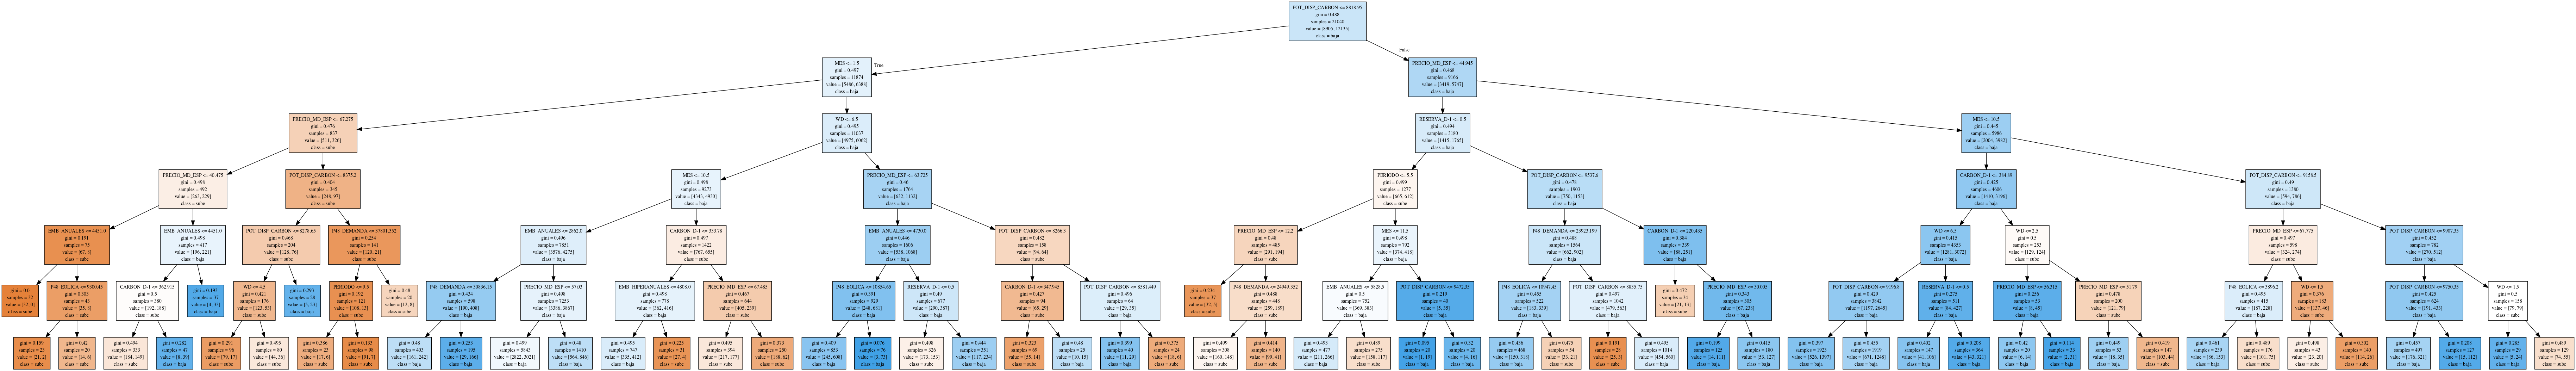

In [25]:
dot_data = tree.export_graphviz(clfd_1,
                                out_file=None, 
                                filled=True,                           #filled le pone un color en funcion de la clase
                                feature_names=attributes_column,
                                class_names=["sube","baja"])            

graph=pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [26]:
accuracy_score(y_test, clfd_1.predict(X_test))

0.6076791484508649

In [27]:
importances = clfd_1.feature_importances_

indices = np.argsort(importances)[::-1]

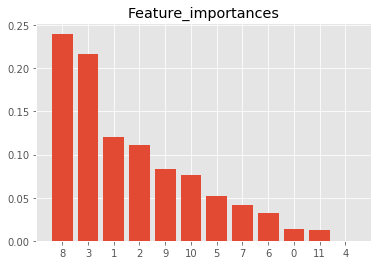

['POT_DISP_CARBON', 'PRECIO_MD_ESP', 'MES', 'WD', 'CARBON_D-1', 'EMB_ANUALES', 'RESERVA_D-1', 'P48_DEMANDA', 'P48_EOLICA', 'PERIODO', 'EMB_HIPERANUALES', 'ACOPLADO_FR']


In [28]:
plt.figure()
plt.title("Feature_importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

print(list([attributes_column[i] for i in indices]))

**NOTA:** Probaré después si mejora el score al eliminar ACOPLADO_FR, EMB_HIPERANUALES, PERIODO.

#### d) Random Forest

In [29]:
clfr_0=RandomForestClassifier(random_state=42)
print(clfr_0.get_params())

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Parámetros a seleccionar:

* **min_samples_leaf**

* **max_depth**

* **n_estimators:** nº árboles

In [30]:
clfr = GridSearchCV(RandomForestClassifier(n_estimators=200, oob_score=True,random_state=42),
                          param_grid={"min_samples_leaf": [10, 20, 30, 50, 100, 150, 200, 250,500],
                                      'max_depth': range(2, 7, 500),
                                      'n_estimators': [100, 200, 500]},
                          scoring="accuracy",
                          cv=10)
clfr.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [10, 20, 30, 50, 100, 150, 200, 250, 500], 'max_depth': range(2, 7, 500), 'n_estimators': [100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [31]:
clfr.best_params_

{'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 500}

In [32]:
clfr.best_score_

0.5815114068441065

In [33]:
clfr_1=clfr.best_estimator_

In [34]:
clfr_1.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

**Ejemplo de árboles que lo forman (500):**

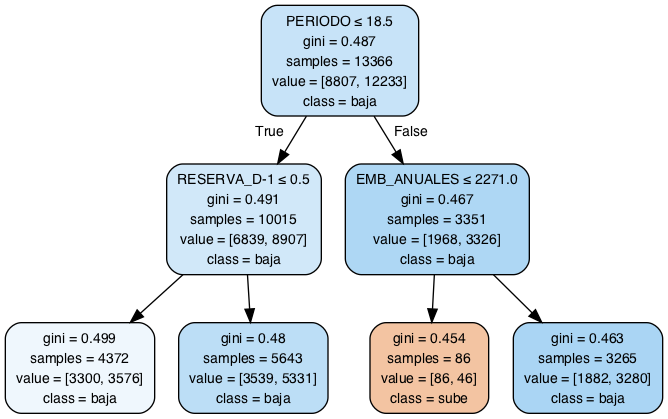

In [40]:
dot_data = tree.export_graphviz(clfr_1.estimators_[25], out_file=None, 
                         filled=True, rounded=True,  
                         special_characters=True,
                         feature_names=attributes_column,
                         class_names=["sube","baja"])  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png()) 

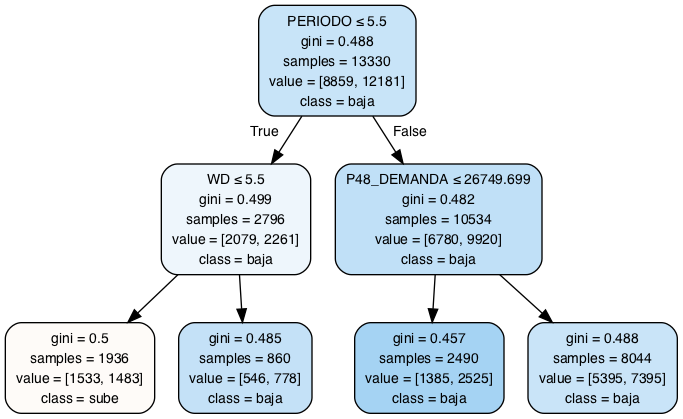

In [89]:
dot_data = tree.export_graphviz(clfr_1.estimators_[350], out_file=None, 
                         filled=True, rounded=True,  
                         special_characters=True,
                         feature_names=attributes_column,
                         class_names=["sube","baja"])  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png()) 

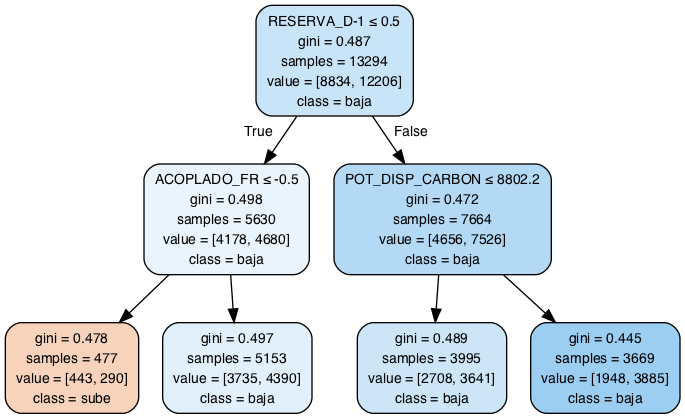

In [90]:
dot_data = tree.export_graphviz(clfr_1.estimators_[100], out_file=None, 
                         filled=True, rounded=True,  
                         special_characters=True,
                         feature_names=attributes_column,
                         class_names=["sube","baja"])  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png()) 

In [41]:
accuracy_score(y_test, clfr_1.predict(X_test))

0.5784071469302414

In [42]:
importances = clfr_1.feature_importances_

indices = np.argsort(importances)[::-1]

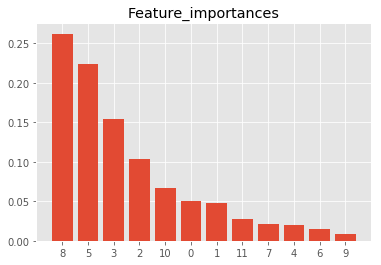

['POT_DISP_CARBON', 'RESERVA_D-1', 'PRECIO_MD_ESP', 'WD', 'EMB_ANUALES', 'PERIODO', 'MES', 'EMB_HIPERANUALES', 'P48_DEMANDA', 'ACOPLADO_FR', 'P48_EOLICA', 'CARBON_D-1']


In [43]:
plt.figure()
plt.title("Feature_importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

print(list([attributes_column[i] for i in indices]))

**NOTA**: En RandomForest obtenemos CARBON_D-1 es la variable que menos aporta al modelo. Continúa estando ACOPLADO_FR entre las menos importantes

#### e) XGBOOST

In [44]:
clfxb_0=XGBClassifier(random_state=42)
print(clfxb_0.get_params())

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}


Parámetros a seleccionar: 

* **n_estimators**

In [45]:
clfxb = GridSearchCV(XGBClassifier(n_estimators=100,random_state=42),
                    param_grid={'n_estimators': [100, 200, 500]},
                    scoring="accuracy",
                    cv=5)
clfxb.fit(X_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [46]:
clfxb.best_params_

{'n_estimators': 500}

In [50]:
clfxb.best_score_

0.6826520912547529

In [51]:
clfxb_1=clfxb.best_estimator_

In [52]:
clfxb_1.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [53]:
accuracy_score(y_test, clfxb_1.predict(X_test))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6962554647405437

In [54]:
importances = clfxb_1.feature_importances_

indices = np.argsort(importances)[::-1]

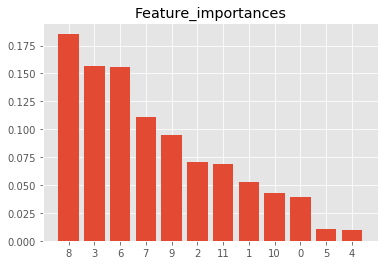

['POT_DISP_CARBON', 'PRECIO_MD_ESP', 'P48_EOLICA', 'P48_DEMANDA', 'CARBON_D-1', 'WD', 'EMB_HIPERANUALES', 'MES', 'EMB_ANUALES', 'PERIODO', 'RESERVA_D-1', 'ACOPLADO_FR']


In [55]:
plt.figure()
plt.title("Feature_importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

print(list([attributes_column[i] for i in indices]))

**NOTA:** Como se intuía en la exploración de datos, la variable ACOPLADO_FR no aporta a los modelos

#### f) Bagging

In [57]:
clfb_0=BaggingClassifier(base_estimator=clfk.best_estimator_,random_state=42)
print(clfxb_0.get_params())

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}


Parámetros a seleccionar:

* **n_estimators**

In [58]:
clfb = GridSearchCV(BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3),n_estimators=100,oob_score=True,random_state=42),
                    param_grid={"n_estimators": [100, 200, 500]},
                    scoring="accuracy",
                    cv=5)
clfb.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=100, n_jobs=1, oob_score=True,
         random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [59]:
clfb.best_score_

0.6387832699619772

In [60]:
clfb.best_params_

{'n_estimators': 200}

In [62]:
clfb_1=clfb.best_estimator_
clfb_1.fit(X_train,y_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=200, n_jobs=1, oob_score=True,
         random_state=42, verbose=0, warm_start=False)

In [63]:
accuracy_score(y_test, clfb_1.predict(X_test))

0.6525375403915605

### 3) Análisis de resultados:

In [120]:
modelos=[clfk_1,clfsvc_1,clfd_1,clfr_1,clfxb_1,clfb_1]

**Clasification Report**

In [98]:
for m in modelos:
    print('Modelo ' + str(m) + '\n')
    print(classification_report(y_test,m.predict(X_test)))

Modelo KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

             precision    recall  f1-score   support

          0       0.60      0.55      0.57      2258
          1       0.68      0.72      0.70      3003

avg / total       0.64      0.65      0.64      5261

Modelo SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00      2258
          1       0.57      1.00      0.73      3003

avg / total       0.33      0.57      0.41      5261

Modelo DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

             precision    recall  f1-score   support

          0       0.62      0.23      0.33      2258
          1       0.61      0.89      0.72      3003

avg / total       0.61      0.61      0.56      5261

Modelo RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
  

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

          0       0.70      0.50      0.59      2258
          1       0.69      0.84      0.76      3003

avg / total       0.70      0.70      0.69      5261

Modelo BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=200, n_jobs=1, oob_score=True,
         random_state=42, verbose=0, warm_start=False)

             precision    recall  f1-score   support

          0       0.60      0.55      0.58      2258
          1       0.68      0.73      0.71      3003

avg / total       0.65      0.65      0.65      5261



Se define:

* **Precisión:** probabilidad de que, dada una predicción positiva, la realidad sea positiva también

* **Recall:** probabilidad de que, dada una observación realmente positiva, el modelo la clasifique así.

![alt text](https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg "Logo Title Text 1")

* Previamente resaltar el warning que devuelve la evaluación del modelo SVM. Esto es debido a que no se ha podido calcular el F-Score en algún caso, es decir, que hay valores de y_test que nunca predice. En el caso de estudio solo hay 2 posibilidades (0,1)

In [121]:
set(y_test)-set(clfsvc_1.predict(X_test))

{0}

**Descarto SVM ya que siempre predice que baja el intra (1). Su % de acierto coincide con el nº de veces que baja el intra en el total del test set**

* En el caso de Random Forest, con un accuracy próximo a 57%, apunta a ocurrir lo mismo: casi siempre predice bajada del intra (1) y por eso el recall es 1 para y=1 mientras que es casi 0 en el caso de acertar la subida del intra.

In [103]:
y_pred_clfr=list(clfr_1.predict(X_test))

In [143]:
((y_pred_clfr==1).sum()/len(y_pred_clfr))*100

98.89754799467781

**Descarto Random Forest ya que un 99% de las veces predice que baja el intra (1)**

* Para el resto de modelos, por la descripción de mi problema, si tengo que fijarme en un único valor lo haré en la **precisión**:

Me interesa que cuando el modelo me diga que el precio del intradiario va a ser más bajo que el del diario, acierte y no me dé un falso 1 (perdería dinero). Cuando el modelo me indique 0 (el precio del intra no es inferior), dependiendo del modelo que escoja y del error que obtenga en estos casos, veré si decido vender en el intradiario (sube el intra) o no hacer nada.

Con esto, el modelo que mejor resultados me arroja tanto en accuracy como en precisión (e incluso en recall para clase=1) es **XGBOOST**.

In [136]:
for m in modelos:
    print('Precision: \n' + list(str(m).split("("))[0])
    print('%.2f' %precision_score(y_test,m.predict(X_test)) + '\n')

for m in modelos:
    print('Accuracy: \n' + list(str(m).split("("))[0])
    print('%.2f' %accuracy_score(y_test,m.predict(X_test)) + '\n')

Precision: 
KNeighborsClassifier
0.68

Precision: 
SVC
0.57

Precision: 
DecisionTreeClassifier
0.61

Precision: 
RandomForestClassifier
0.58

Precision: 
XGBClassifier
0.69

Precision: 
BaggingClassifier


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.68

Accuracy: 
KNeighborsClassifier
0.65

Accuracy: 
SVC
0.57

Accuracy: 
DecisionTreeClassifier
0.61

Accuracy: 
RandomForestClassifier
0.58

Accuracy: 
XGBClassifier
0.70

Accuracy: 
BaggingClassifier


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.65



**Matriz de Confusión**

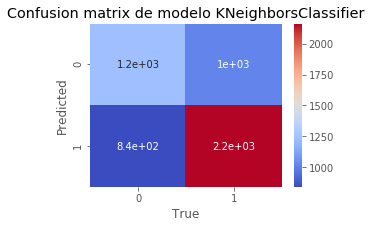

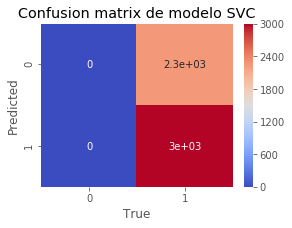

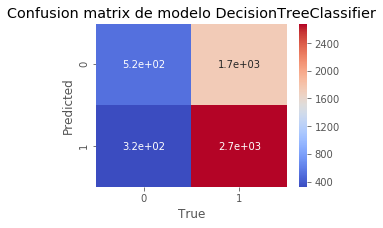

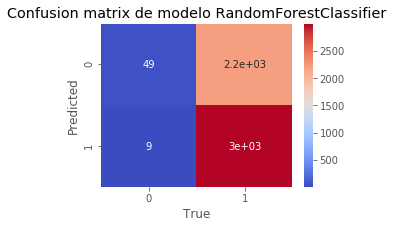

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


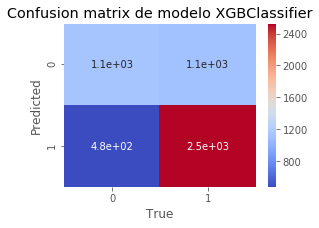

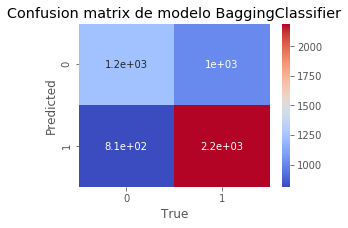

In [145]:
for k,m in enumerate(modelos):
    plt.figure(figsize=(30,3))
    plt.subplot(1,6,k+1)
    cmatrix=confusion_matrix(y_test,m.predict(X_test))
    sns.heatmap(data = cmatrix, 
                annot=True,
                xticklabels=[0,1], 
                yticklabels=[0,1],
                cmap='coolwarm')
    plt.ylabel('Predicted')
    plt.xlabel('True')
    plt.title('Confusion matrix de modelo ' + list(str(m).split("("))[0])
    plt.show()

Corroboro resultados observados en el anterior análisis.

* **Falsos 1:** Perdería dinero si compro en el MI1 -> es el que menos valores tiene.

* **Falsos 0:** Viendo que practicamente tengo el mismo número de falsos 0 que de verdaderos 0 en el modelo a priori seleccionado (**XGBoost**), ante un 0 en el modelo, no arriesgaría comprando de más en el MD y vendiendo después en el MI1, simplemente no haría nada (que no supone pérdida econímica real, solo pérdida de oportunidad).

Guardo los modelos obtenidos (ya entrenados) y la división del train_test_set para, en un notebook posterior, ver si eliminando el features ACOPLADO_FR mejora el modelo.

In [155]:
names=['clfk_1','clfsvc_1','clfd_1','clfr_1','clfxb_1','clfb_1']

for k,m in enumerate(modelos):
    pickle.dump(m,open("Modelo1/" + names[k] +".pkl","wb"))

In [156]:
#set de datos
pickle.dump(X_train,open("Modelo1/X_train.pkl","wb"))
pickle.dump(y_train,open("Modelo1/y_train.pkl","wb"))
pickle.dump(X_test,open("Modelo1/X_test.pkl","wb"))
pickle.dump(y_test,open("Modelo1/y_test.pkl","wb"))